# Pan01 Bottom Temperature in map sectors

In [1]:
import intake
import glob
import dask.distributed as dsk
import matplotlib.pyplot as plt
import xarray as xr
import cf_xarray as cfxr
import numpy as np
import xesmf as xe
import gsw

import cmocean as cm
import cartopy.crs as ccrs

import cartopy.feature as cft
import matplotlib.path as mpath

import warnings # ignore these warnings
warnings.filterwarnings("ignore", category = FutureWarning)
warnings.filterwarnings("ignore", category = UserWarning)
warnings.filterwarnings("ignore", category = RuntimeWarning)

In [2]:
import logging
logging.getLogger("matplotlib").setLevel(logging.WARNING)

In [3]:
from dask.distributed import Client
client = Client(threads_per_worker=1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 28
Total threads: 28,Total memory: 125.19 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:44767,Workers: 28
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 125.19 GiB
Comm: tcp://127.0.0.1:40139,Total threads: 1
Dashboard: /proxy/34331/status,Memory: 4.47 GiB
Nanny: tcp://127.0.0.1:38441,


2025-08-18 09:41:20,173 - distributed.scheduler - WARNING - Detected different `run_spec` for key ('getitem-1b7344e5a31d367d3836ab9afb972c05', 1, 0) between two consecutive calls to `update_graph`. This can cause failures and deadlocks down the line. Please ensure unique key names. If you are using a standard dask collections, consider releasing all the data before resubmitting another computation. More details and help can be found at https://github.com/dask/dask/issues/9888. 
Debugging information
---------------------
old task state: released
old run_spec: <Task ('getitem-1b7344e5a31d367d3836ab9afb972c05', 1, 0) getitem(...)>
new run_spec: Alias(('getitem-1b7344e5a31d367d3836ab9afb972c05', 1, 0)->('concatenate-rechunk-merge-where-getitem-1b7344e5a31d367d3836ab9afb972c05', 1, 0))
old dependencies: {('getitem-c1c95c10751d7cb21d5c3f558248261c', 0, 0, 1, 0)}
new dependencies: {('concatenate-rechunk-merge-where-getitem-1b7344e5a31d367d3836ab9afb972c05', 1, 0)}

2025-08-18 09:54:34,781 - 

In [4]:
# Importing data

pathsC = np.sort(glob.glob('/g/data/ol01/outputs/mom6-panan/panant-01-zstar-ACCESSyr2/*/*.ocean_month_z.nc'))
pathsM = np.sort(glob.glob('/g/data/g40/akm157/model_output/mom6-panan/panant-01-zstar-ssp126-MW-only/*/*.ocean_month_z.nc'))

In [5]:
## Creating shelf mask another way

def shelf_mask_isobath(var, model_dict):

    paths = {
             "mom5": "/g/data/ik11/grids/Antarctic_slope_contour_1000m.npz",
             "mom6_01": "/g/data/ik11/grids/Antarctic_slope_contour_1000m_MOM6_01deg.nc",
            "mom6_005": "/g/data/ik11/grids/Antarctic_slope_contour_1000m_MOM6_005deg.nc"
             }

    var = var.cf.sel({'latitude': slice(-90, -59)})

    if paths[model_dict][-3:] == '.nc':
        shelf_mask = xr.open_dataset(paths[model_dict])['contour_masked_above']
    else:
        contour_file = np.load(paths[model_dict])
        shelf_mask = xr.DataArray(contour_file['contour_masked_above'],
                                  coords = var.coords, 
                                  dims = var.dims,
                                  name = 'contour_masked_above')
    
    shelf_mask = xr.where(shelf_mask == 0, 1, 0)
    masked_var = var * shelf_mask
    
    return masked_var, shelf_mask

In [6]:
depth = xr.open_dataset('/g/data/ol01/outputs/mom6-panan/panant-01-zstar-ACCESSyr2/output050/20050501.ocean_static.nc')['deptho']
land_mask = (0 * depth).fillna(1)
depth_shelf, shelf_mask = shelf_mask_isobath(depth, 'mom6_01')

In [7]:
# Time variant variables
def preprocess(ds):
    ds = ds[['thetao','so']].where(shelf_mask == 1)
    return ds

cont = xr.open_mfdataset(pathsC, preprocess = preprocess, chunks = 'auto')
melt = xr.open_mfdataset(pathsM, preprocess = preprocess, chunks = 'auto')

In [8]:
#Time slicing
cont = cont.sel(time=slice('2001-01-01','2010-12-31'))
melt = melt.sel(time=slice('2001-01-01','2010-12-31'))

In [9]:
#Time invariant variables
area = xr.open_dataset('/g/data/ol01/outputs/mom6-panan/panant-01-zstar-ACCESSyr2/output050/20050501.ocean_static.nc')['areacello']


In [10]:
# Variable for landmask
saltC = cont['so']
saltM = melt['so']

In [11]:
# Correcting area
area_corr = area*(saltC.isel(time=0,z_l=0)*0 +1)

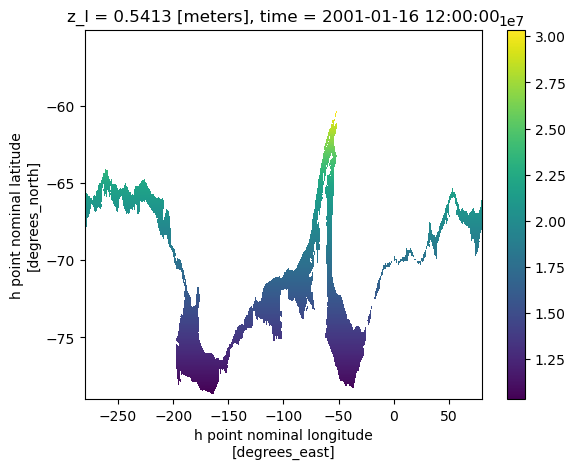

In [12]:
area_corr.plot()

#### Using these sectors:

In [13]:
# Define in longitude space what the cut-off values for regions should be.
AdelieW = -280
AdelieE = -200
RossW = -200
RossE = -150
AmW = -150
AmE = -100
BeW = -100
BeE = -65

WeddellW = -65
WeddellE = 0
PrydzW = 0
PrydzE = 80

Adelie = slice(AdelieW,AdelieE)
Ross = slice(RossW, RossE)
Am = slice(AmW, AmE)
Be = slice(BeW,BeE)
Weddell = slice(WeddellW, WeddellE)
Prydz = slice(PrydzW, PrydzE)

### Calculating temperature

In [14]:
# Calculating pressure
p_cont = gsw.p_from_z(-cont['z_l'], cont['yh'])
p_melt = gsw.p_from_z(-melt['z_l'], melt['yh'])

# Calculating absolute salinity
SA_cont = gsw.SA_from_SP(cont['so'], p_cont, cont['xh'], cont['yh'])
SA_melt =  gsw.SA_from_SP(melt['so'], p_melt, melt['xh'], melt['yh'])

# Calculating conservative temperature
tempC = gsw.CT_from_pt(SA_cont,cont['thetao'])
tempM = gsw.CT_from_pt(SA_melt,melt['thetao'])

In [15]:
# To fix the label issues
tempC = xr.DataArray(tempC, dims=cont['thetao'].dims, coords=cont['thetao'].coords)
tempC.attrs['units'] = '°C'
tempC.name = 'CT'

tempM = xr.DataArray(tempM, dims=melt['thetao'].dims, coords=melt['thetao'].coords)
tempM.attrs['units'] = '°C'
tempM.name = 'CT'

In [16]:
tempC = tempC.astype('float32')
tempM = tempM.astype('float32')
tempM

<xarray.DataArray 'CT' (time: 120, z_l: 75, yh: 533, xh: 3600)> Size: 69GB
dask.array<astype, shape=(120, 75, 533, 3600), dtype=float32, chunksize=(2, 22, 211, 1030), chunktype=numpy.ndarray>
Coordinates:
  * xh       (xh) float64 29kB -279.9 -279.8 -279.7 -279.6 ... 79.75 79.85 79.95
  * yh       (yh) float64 4kB -79.0 -78.95 -78.91 ... -55.18 -55.12 -55.07
  * z_l      (z_l) float64 600B 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * time     (time) object 960B 2001-01-16 12:00:00 ... 2010-12-16 12:00:00
Attributes:
    units:          °C
    long_name:      Sea Water Salinity
    cell_methods:   area:mean z_l:mean yh:mean xh:mean time: mean
    cell_measures:  volume: volcello area: areacello
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_water_salinity

### Bottom mask

In [17]:
bottom_mask_tempC = tempC.where(~np.isfinite(tempC.shift({'z_l': -1})))
bottom_mask_tempC = ~np.isnan(bottom_mask_tempC)

In [18]:
bottom_mask_tempM = tempM.where(~np.isfinite(tempM.shift({'z_l': -1})))
bottom_mask_tempM = ~np.isnan(bottom_mask_tempM)

In [19]:
bottemp_cont = tempC.where(bottom_mask_tempC).sum(dim='z_l')
bottemp_pert = tempM.where(bottom_mask_tempM).sum(dim='z_l')

### Time series

In [22]:
# Restricting to regions
bottemp_cont_1 = bottemp_cont.sel(xh=Adelie)
bottemp_pert_1 = bottemp_pert.sel(xh=Adelie)

bottemp_cont_2 = bottemp_cont.sel(xh=Ross)
bottemp_pert_2 = bottemp_pert.sel(xh=Ross)

bottemp_cont_3 = bottemp_cont.sel(xh=Am)
bottemp_pert_3 = bottemp_pert.sel(xh=Am)

bottemp_cont_4 = bottemp_cont.sel(xh=Be)
bottemp_pert_4 = bottemp_pert.sel(xh=Be)

bottemp_cont_5 = bottemp_cont.sel(xh=Weddell)
bottemp_pert_5 = bottemp_pert.sel(xh=Weddell)

bottemp_cont_6 = bottemp_cont.sel(xh=Prydz)
bottemp_pert_6 = bottemp_pert.sel(xh=Prydz)

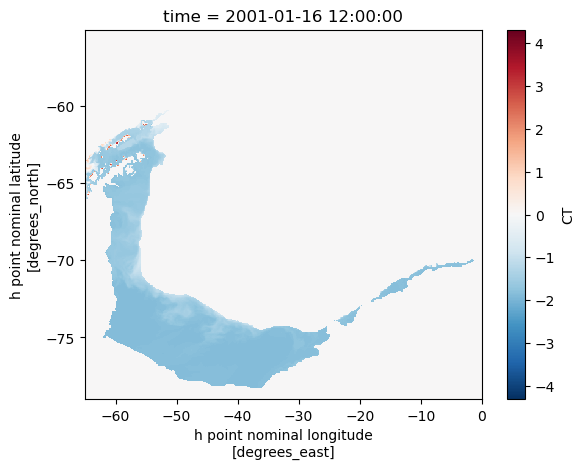

In [23]:
# Checking mask
bottemp_cont_5.isel(time=0).plot()

In [24]:
# Spatial averages
bottemp_cont_1_time = (area_corr * bottemp_cont_1).sum(['xh', 'yh']) / area_corr.sel(xh=Adelie).sum(['xh', 'yh'])
bottemp_pert_1_time = (area_corr * bottemp_pert_1).sum(['xh', 'yh']) / area_corr.sel(xh=Adelie).sum(['xh', 'yh'])

bottemp_cont_2_time = (area_corr * bottemp_cont_2).sum(['xh', 'yh']) / area_corr.sel(xh=Ross).sum(['xh', 'yh'])
bottemp_pert_2_time = (area_corr * bottemp_pert_2).sum(['xh', 'yh']) / area_corr.sel(xh=Ross).sum(['xh', 'yh'])

bottemp_cont_3_time = (area_corr * bottemp_cont_3).sum(['xh', 'yh']) / area_corr.sel(xh=Am).sum(['xh', 'yh'])
bottemp_pert_3_time = (area_corr * bottemp_pert_3).sum(['xh', 'yh']) / area_corr.sel(xh=Am).sum(['xh', 'yh'])

bottemp_cont_4_time = (area_corr * bottemp_cont_4).sum(['xh', 'yh']) / area_corr.sel(xh=Be).sum(['xh', 'yh'])
bottemp_pert_4_time = (area_corr * bottemp_pert_4).sum(['xh', 'yh']) / area_corr.sel(xh=Be).sum(['xh', 'yh'])

bottemp_cont_5_time = (area_corr * bottemp_cont_5).sum(['xh', 'yh']) / area_corr.sel(xh=Weddell).sum(['xh', 'yh'])
bottemp_pert_5_time = (area_corr * bottemp_pert_5).sum(['xh', 'yh']) / area_corr.sel(xh=Weddell).sum(['xh', 'yh'])

bottemp_cont_6_time = (area_corr * bottemp_cont_6).sum(['xh', 'yh']) / area_corr.sel(xh=Prydz).sum(['xh', 'yh'])
bottemp_pert_6_time = (area_corr * bottemp_pert_6).sum(['xh', 'yh']) / area_corr.sel(xh=Prydz).sum(['xh', 'yh'])

In [25]:
# Check shape
bottemp_cont_1_time

<xarray.DataArray (time: 120)> Size: 480B
dask.array<truediv, shape=(120,), dtype=float32, chunksize=(2,), chunktype=numpy.ndarray>
Coordinates:
    z_l      float64 8B 0.5413
  * time     (time) object 960B 2001-01-16 12:00:00 ... 2010-12-16 12:00:00

In [26]:
bottemp_cont_1_time = bottemp_cont_1_time.load()
bottemp_pert_1_time = bottemp_pert_1_time.load()

In [27]:
bottemp_cont_2_time = bottemp_cont_2_time.load()
bottemp_pert_2_time = bottemp_pert_2_time.load()

In [28]:
bottemp_cont_3_time = bottemp_cont_3_time.load()
bottemp_pert_3_time = bottemp_pert_3_time.load()

2025-08-18 09:47:32,277 - distributed.worker - ERROR - Worker stream died during communication: tcp://127.0.0.1:40691
Traceback (most recent call last):
  File "/g/data/xp65/public/apps/med_conda/envs/analysis3-25.04/lib/python3.11/site-packages/tornado/iostream.py", line 861, in _read_to_buffer
    bytes_read = self.read_from_fd(buf)
                 ^^^^^^^^^^^^^^^^^^^^^^
  File "/g/data/xp65/public/apps/med_conda/envs/analysis3-25.04/lib/python3.11/site-packages/tornado/iostream.py", line 1116, in read_from_fd
    return self.socket.recv_into(buf, len(buf))
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
ConnectionResetError: [Errno 104] Connection reset by peer

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/g/data/xp65/public/apps/med_conda/envs/analysis3-25.04/lib/python3.11/site-packages/distributed/worker.py", line 2075, in gather_dep
    response = await get_data_from_worker(
               ^^^^^^^^^^^^^^^^^^^^

In [29]:
bottemp_cont_4_time = bottemp_cont_4_time.load()
bottemp_pert_4_time = bottemp_pert_4_time.load()

2025-08-18 09:50:39,310 - distributed.worker - ERROR - Worker stream died during communication: tcp://127.0.0.1:33885
Traceback (most recent call last):
  File "/g/data/xp65/public/apps/med_conda/envs/analysis3-25.04/lib/python3.11/site-packages/tornado/iostream.py", line 861, in _read_to_buffer
    bytes_read = self.read_from_fd(buf)
                 ^^^^^^^^^^^^^^^^^^^^^^
  File "/g/data/xp65/public/apps/med_conda/envs/analysis3-25.04/lib/python3.11/site-packages/tornado/iostream.py", line 1116, in read_from_fd
    return self.socket.recv_into(buf, len(buf))
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
ConnectionResetError: [Errno 104] Connection reset by peer

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/g/data/xp65/public/apps/med_conda/envs/analysis3-25.04/lib/python3.11/site-packages/distributed/worker.py", line 2075, in gather_dep
    response = await get_data_from_worker(
               ^^^^^^^^^^^^^^^^^^^^

In [30]:
bottemp_cont_5_time = bottemp_cont_5_time.load()
bottemp_pert_5_time = bottemp_pert_5_time.load()

In [31]:
bottemp_cont_6_time = bottemp_cont_6_time.load()
bottemp_pert_6_time = bottemp_pert_6_time.load()

In [32]:
bottemp_anom_1_time = bottemp_pert_1_time - bottemp_cont_1_time
bottemp_anom_1_time = bottemp_anom_1_time.load()
bottemp_anom_1_time.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/bottemp_anom_Adelie_pan01.nc')

In [33]:
bottemp_anom_2_time = bottemp_pert_2_time - bottemp_cont_2_time
bottemp_anom_2_time = bottemp_anom_2_time.load()
bottemp_anom_2_time.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/bottemp_anom_Ross_pan01.nc')

In [34]:
bottemp_anom_3_time = bottemp_pert_3_time - bottemp_cont_3_time
bottemp_anom_3_time = bottemp_anom_3_time.load()
bottemp_anom_3_time.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/bottemp_anom_Am_pan01.nc')

In [35]:
bottemp_anom_4_time = bottemp_pert_4_time - bottemp_cont_4_time
bottemp_anom_4_time = bottemp_anom_4_time.load()
bottemp_anom_4_time.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/bottemp_anom_Be_pan01.nc')

In [36]:
bottemp_anom_5_time = bottemp_pert_5_time - bottemp_cont_5_time
bottemp_anom_5_time = bottemp_anom_5_time.load()
bottemp_anom_5_time.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/bottemp_anom_Weddell_pan01.nc')

In [37]:
bottemp_anom_6_time = bottemp_pert_6_time - bottemp_cont_6_time
bottemp_anom_6_time = bottemp_anom_6_time.load()
bottemp_anom_6_time.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/bottemp_anom_Prydz_pan01.nc')

#### All regions in one plot

Text(0.5, 1.0, 'Pan01 Time Series of Bottom Temperature on Shelf, Sector regions')

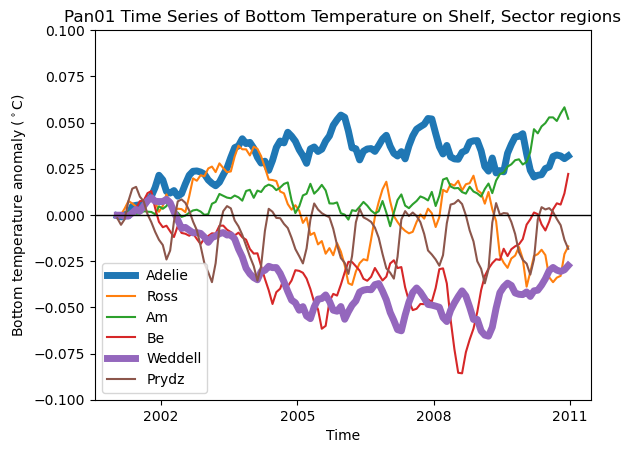

In [48]:
bottemp_anom_1_time.plot(label="Adelie",linewidth=5)
bottemp_anom_2_time.plot(label="Ross")
bottemp_anom_3_time.plot(label="Am")
bottemp_anom_4_time.plot(label="Be")
bottemp_anom_5_time.plot(label="Weddell", linewidth=5)
bottemp_anom_6_time.plot(label="Prydz")
plt.ylim(-0.1,0.1)
plt.axhline(y=0, color='black', linewidth=1)
plt.xlabel("Time")
plt.ylabel("Bottom temperature anomaly ($^\circ$C)")
plt.legend(loc="lower left")
plt.title("Pan01 Time Series of Bottom Temperature on Shelf, Sector regions")